# BONOs:Precio, Duración y Aproximación por Duración


## Precio, Duración y Aproximación por Duración  


---

### **Objetivos del notebook**
- Repasar cómo se calcula el **precio** de un bono.
- Implementar:
  - **Duración de Macaulay**
  - **Duración Modificada**
- Crear curvas:
  - Precio vs. YTM  
  - Duración vs. Madurez
- Comparar:
  - Precio exacto  
  - Precio aproximado por duración  

---


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True


# 1. Precio de un bono

La fórmula del precio de un bono con pagos regulares es:

$
P = \sum_{t=1}^{m} \frac{C}{(1 + y/m)^t} + \frac{F}{(1+y/m)^m}
$

Donde:
- \(F\) = valor nominal  
- \(C\) = cupón por período  
- \(y\) = rendimiento anual (YTM)  
- \(m\) = número total de pagos  

Implementaremos una función llamada `bond_price()`.


In [26]:
def bond_price(face, coupon_rate, ytm, n_years, freq=1):
    """
    Precio de un bono con cupones regulares.

    face        : valor nominal
    coupon_rate : cupón ANUAL (0.04 = 4%)
    ytm         : rendimiento ANUAL
    n_years     : años a vencimiento
    freq        : número de pagos por año
    """
    m = int(n_years * freq)
    c = face * coupon_rate / freq
    y_per = ytm / freq

    t = np.arange(1, m + 1)
    cash_flows = np.full(m, c)
    cash_flows[-1] += face  # principal en el último pago

    discount = 1 / (1 + y_per)**t
    return np.sum(cash_flows * discount)


## Ejercicio
### Construimos una tabla Precio vs YTM

- Mantén fijo:  
  - face = 1000  
  - coupon = 4%  
  - n_years = 10  
- Variar YTM desde 1% hasta 15%.
- Graficar YTM vs Precio.



In [27]:
face = 1000
coupon = 0.04
n_years = 10

ytms = np.linspace(0.01, 0.15, 20)
prices = [bond_price(face, coupon, y, n_years) for y in ytms]

df_price = pd.DataFrame({"YTM": ytms, "Precio": prices})
df_price


,YTM,Precio
0,0.010000,1284.139136
1,0.017368,1206.117805
2,0.024737,1133.765967
3,0.032105,1066.625910
4,0.039474,1004.280099
5,0.046842,946.347383
6,0.054211,892.479587
7,0.061579,842.358441
8,0.068947,795.692816
9,0.076316,752.216235


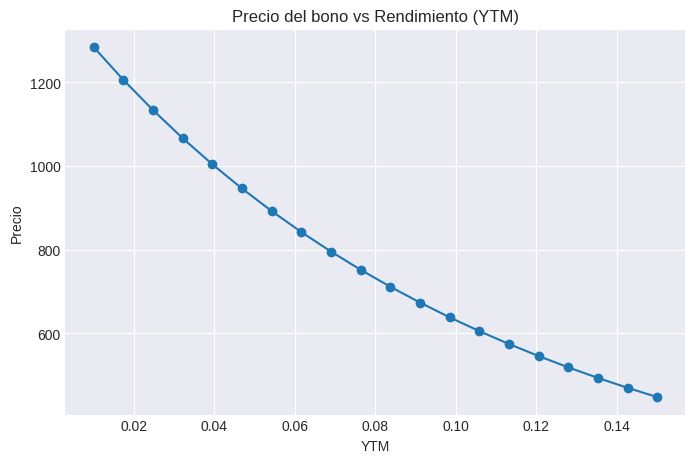

In [60]:
plt.plot(ytms, prices, marker="o")
plt.style.use('seaborn-v0_8-darkgrid')
plt.title("Precio del bono vs Rendimiento (YTM)")
plt.xlabel("YTM")
plt.ylabel("Precio")
plt.show()


# 2. Duración de Macaulay y Duración Modificada

Duración de Macaulay:

$
D_M = \frac{\sum t \cdot \frac{CF_t}{(1+y/m)^t}}
          {\sum        \frac{CF_t}{(1+y/m)^t}}
$

Duración Modificada:

$
D_{mod} = \frac{D_M}{1 + y/m}
$

Implementaremos:
- `macaulay_duration()`
- `modified_duration()`


In [29]:
def macaulay_duration(face, coupon_rate, ytm, n_years, freq=1):
    m = int(n_years * freq)
    c = face * coupon_rate / freq
    y_per = ytm / freq

    t = np.arange(1, m + 1)
    cash_flows = np.full(m, c)
    cash_flows[-1] += face

    discount = 1 / (1 + y_per)**t
    price = np.sum(cash_flows * discount)

    D_per = np.sum(t * cash_flows * discount) / price
    return D_per / freq  # convertir a años


def modified_duration(face, coupon_rate, ytm, n_years, freq=1):
    D_mac = macaulay_duration(face, coupon_rate, ytm, n_years, freq)
    return D_mac / (1 + ytm / freq)


# 3. Aproximación del precio usando duración modificada

Fórmula:

$
P_{\text{aprox}} = P_0 (1 - D_{mod} \cdot \Delta y)
$

Implementaremos la función:

- `price_using_duration_approx(P0, D_mod, y_old, y_new)`


In [30]:
def price_using_duration_approx(P0, D_mod, y_old, y_new):
    dy = y_new - y_old
    return P0 * (1 - D_mod * dy)


## Ejercicio
### Comparar precio directo vs precio aproximado por duración

Tarea:
1. Fijar:
   - face = 1000  
   - coupon = 4%  
   - n_years = 10  
   - YTM inicial = 7%  
2. Crear una columna de YTM nuevo (1% a 15%).
3. Para cada YTM:
   - Calcular precio directo → `bond_price()`
   - Calcular precio por duración → `price_using_duration_approx()`
4. Graficar ambas curvas.



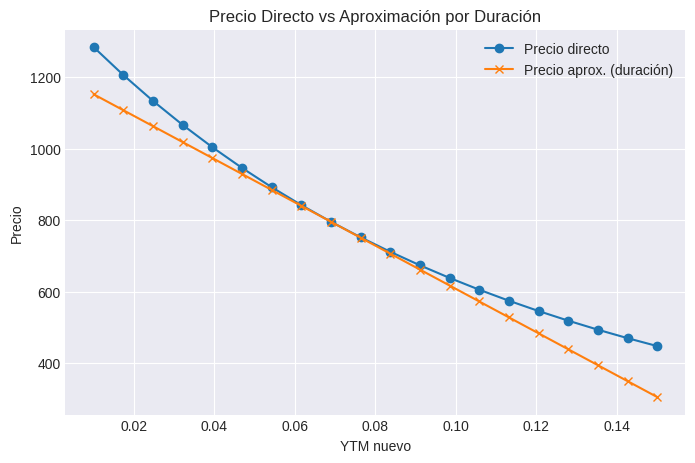

In [31]:
face = 1000
coupon = 0.04
n_years = 10
y0 = 0.07  # rendimiento inicial

P0 = bond_price(face, coupon, y0, n_years)
D_mod = modified_duration(face, coupon, y0, n_years)

ytms_new = np.linspace(0.01, 0.15, 20)

prices_direct = [bond_price(face, coupon, y, n_years) for y in ytms_new]
prices_approx = [price_using_duration_approx(P0, D_mod, y0, y) for y in ytms_new]

plt.plot(ytms_new, prices_direct, label="Precio directo", marker="o")
plt.plot(ytms_new, prices_approx, label="Precio aprox. (duración)", marker="x")
plt.legend()
plt.title("Precio Directo vs Aproximación por Duración")
plt.xlabel("YTM nuevo")
plt.ylabel("Precio")
plt.style.use('seaborn-v0_8-darkgrid')
plt.show()


# Conclusiones

- El precio del bono cae cuando sube el YTM.
- La duración mide sensibilidad del precio al rendimiento.
- La aproximación basada en duración funciona bien para cambios pequeños en el YTM.
- Para cambios grandes en YTM, aparece error → necesitamos convexidad



## Convexidad de Bonos e Inmunización

Ahora vamos a extender las ideas de duración:

**Objetivos:**
- Definir e implementar la **convexidad** de un bono.
- Comparar tres precios:
  - Precio directo (exacto).
  - Precio aproximado usando **solo duración**.
  - Precio aproximado usando **duración + convexidad**.
- Introducir el concepto de **inmunización**:
  - Construir un portafolio de bonos que replique el valor presente y la duración de un pasivo (liability).



# 1. Convexidad de un bono

La **duración** aproxima el cambio de precio de un bono ante pequeños cambios
en el rendimiento $ y $ mediante una aproximación lineal:

$
\frac{\Delta P}{P} \approx -D_{\text{mod}} \, \Delta y
$

Pero la relación real entre $ P $ y $y$ es **curva** (convexa), no una línea recta.
Para capturar esta curvatura usamos la **convexidad**.

Para un bono con pagos regulares (periodicidad `freq`):

$
\text{Convexidad}_{\text{períodos}} =
\frac{\sum_{t=1}^{m} t (t+1) \frac{CF_t}{(1+y/freq)^{t+2}}}
{\sum_{t=1}^{m} \frac{CF_t}{(1+y/freq)^t}}
$

Podemos transformar esta convexidad a unidades de **años** dividiendo por \(freq^2\):

$
\text{Convexidad}_{\text{años}} = \frac{\text{Convexidad}_{\text{períodos}}}{freq^2}
$

Usaremos la siguiente aproximación de segundo orden:

$
\frac{\Delta P}{P} \approx
- D_{\text{mod}} \, \Delta y
+ \frac{1}{2}\, \text{Convexidad} \, (\Delta y)^2
$


#Funciòn de Convexidad

In [32]:
def convexity(face, coupon_rate, ytm, n_years, freq=1):
    """
    Convexidad de un bono en AÑOS^2.

    Devuelve la convexidad 'total' (no normalizada por precio relativo),
    consistente con la aproximación:
         ΔP / P ≈ -D_mod * Δy + 0.5 * Conv * (Δy)^2
    """
    m = int(n_years * freq)
    c = face * coupon_rate / freq
    y_per = ytm / freq

    t = np.arange(1, m + 1)
    cash_flows = np.full(m, c)
    cash_flows[-1] += face

    discount = 1 / (1 + y_per) ** t
    price = np.sum(cash_flows * discount)

    # Convexidad en "periodos"
    conv_per = np.sum(t * (t + 1) * cash_flows * discount / (1 + y_per) ** 2) / price

    # Convertir a "años^2"
    conv_years = conv_per / (freq ** 2)
    return conv_years


## Probamos la convexidad en un ejemplo

Tomemos el mismo bono del ejemplo 1:

- Valor nominal: 1000  
- Cupón: 4% anual  
- Madurez: 10 años  
- YTM inicial: 7%  

Vamos a calcular:

- Precio inicial \(P_0\)
- Duración modificada
- Convexidad


In [33]:
face = 1000
coupon = 0.04
n_years = 10
y0 = 0.07

P0 = bond_price(face, coupon, y0, n_years)
D_mod = modified_duration(face, coupon, y0, n_years)
Conv = convexity(face, coupon, y0, n_years)

print(f"Precio Inicial = {P0:.2f}")
print(f"Duraciòn Modificada = {D_mod:.2f}")
print(f"Convexidad = {Conv:.2f}")


Precio Inicial = 789.29
Duraciòn Modificada = 7.66
Convexidad = 73.53


# 2. Comparación de aproximaciones de precio

Construiremos una tabla con distintos valores de YTM nuevo \( y_1 \) y, para cada uno:

1. **Precio directo** → usando `bond_price`.
2. **Aproximación con duración**:
   $
   P_D = P_0 \, (1 - D_{\text{mod}} \, \Delta y)
   $
3. **Aproximación con duración + convexidad**:
   $
   P_{DC} = P_0 \, \left( 1 - D_{\text{mod}} \, \Delta y
      + \tfrac{1}{2} \text{Conv} (\Delta y)^2 \right)
   $

donde $\Delta y = y_1 - y_0$.


In [34]:
def price_duration_only(P0, D_mod, y_old, y_new):
    dy = y_new - y_old
    return P0 * (1 - D_mod * dy)

def price_duration_convexity(P0, D_mod, Conv, y_old, y_new):
    dy = y_new - y_old
    return P0 * (1 - D_mod * dy + 0.5 * Conv * dy**2)

# Rango de nuevos YTM
ytm_new_grid = np.linspace(0.01, 0.15, 25)

price_direct = []
price_D = []
price_DC = []

for y1 in ytm_new_grid:
    price_direct.append(bond_price(face, coupon, y1, n_years))
    price_D.append(price_duration_only(P0, D_mod, y0, y1))
    price_DC.append(price_duration_convexity(P0, D_mod, Conv, y0, y1))

df_conv = pd.DataFrame({
    "YTM_nuevo": ytm_new_grid,
    "Precio_directo": price_direct,
    "Precio_duracion": price_D,
    "Precio_dur_conv": price_DC
})
df_conv.head()


,YTM_nuevo,Precio_directo,Precio_duracion,Precio_dur_conv
0,0.010000,1284.139136,1152.267783,1256.733556
1,0.015833,1221.888724,1116.978524,1202.118936
2,0.021667,1163.253880,1081.689266,1149.479170
3,0.027500,1108.000952,1046.400008,1098.814258
4,0.033333,1055.912733,1011.110749,1050.124202


Gràfica Comparativa

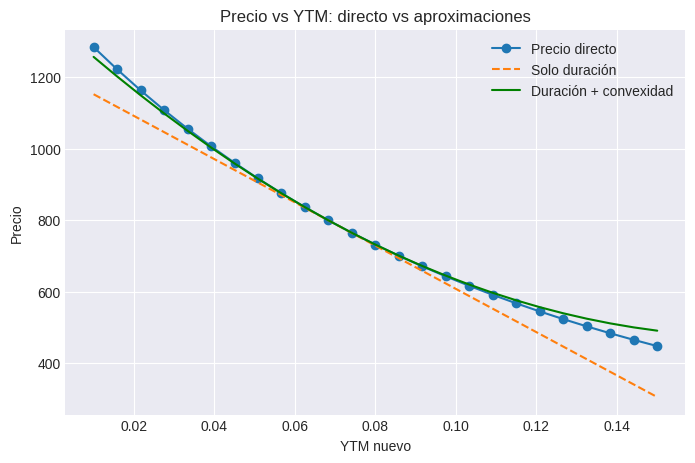

In [53]:
plt.plot(df_conv["YTM_nuevo"], df_conv["Precio_directo"], label="Precio directo", marker="o")
plt.plot(df_conv["YTM_nuevo"], df_conv["Precio_duracion"], label="Solo duración", linestyle="--")
plt.plot(df_conv["YTM_nuevo"], df_conv["Precio_dur_conv"], label="Duración + convexidad", linestyle="-", color="green")
plt.xlabel("YTM nuevo")
plt.ylabel("Precio")
plt.title("Precio vs YTM: directo vs aproximaciones")
plt.style.use('seaborn-v0_8-darkgrid')
plt.legend()
plt.show()


### Comentario
- Para cambios **pequeños** en el rendimiento, duración sola funciona bastante bien.
- Para cambios **grandes**, la aproximación lineal se aleja y la curva de
  **duración + convexidad** se pega mucho más al precio directo.
- Esta mejora es clave cuando se maneja riesgo de tasa de interés en portafolios grandes.


# 3. Inmunización clásica con dos bonos

**Idea básica de inmunización:**

Queremos cubrir (hedgear) un pasivo futuro \( L \) que vence en \( T_L \) años.
La estrategia clásica:

1. Construir un portafolio de bonos cuyo:
   - **Valor presente** sea igual al valor presente del pasivo.
   - **Duración** sea igual a la duración (horizonte) del pasivo.

2. Si logramos eso, el portafolio queda "inmunizado" ante pequeños
   movimientos en la tasa de interés (al menos en teoría).

---

### Pasivo

Supongamos:
- Pasivo único de monto \( L \), pagadero en \( T_L \) años.
- Tasa de interés plana \( y \) (para descontar).

Entonces:
- Valor presente del pasivo:
  $
  PV_L = \frac{L}{(1+y)^{T_L}}
  $
- Duración (Macaulay) del pasivo:
  $
  D_L = T_L \quad (\text{porque es un flujo único en } T_L)
  $

---

### Portafolio con dos bonos

Tenemos dos bonos (**Bono A** y **Bono B**) con:
- Precios: \(P_A\), \(P_B\)
- Duraciones: \(D_A\), \(D_B\)

Buscamos pesos $w_A$ y $w_B$ (monto invertido en cada bono) tales que:

1. Igualar valor presente:
   $
   w_A P_A + w_B P_B = PV_L
   $
2. Igualar "dólares duración":
   $
   w_A P_A D_A + w_B P_B D_B = PV_L D_L
   $

Esto es un sistema de 2 ecuaciones con 2 incógnitas $w_A, w_B$.  
Lo resolveremos con álgebra lineal (`numpy.linalg.solve`).


In [36]:
def immunize_two_bonds(
    L, T_L, y,
    face_A, coupon_A, n_years_A,
    face_B, coupon_B, n_years_B,
    freq=1
):
    """
    Calcula los pesos w_A y w_B de dos bonos (A y B) para inmunizar
    un pasivo único L a tiempo T_L, con tasa plana y.

    Devuelve:
    - w_A, w_B
    - algunos datos en un diccionario
    """
    # Valor presente y duración del pasivo
    PV_L = L / (1 + y) ** T_L
    D_L = T_L  # flujo único

    # Precio y duración de cada bono
    P_A = bond_price(face_A, coupon_A, y, n_years_A, freq)
    D_A = macaulay_duration(face_A, coupon_A, y, n_years_A, freq)

    P_B = bond_price(face_B, coupon_B, y, n_years_B, freq)
    D_B = macaulay_duration(face_B, coupon_B, y, n_years_B, freq)

    # Sistema:
    # [ P_A   P_B ] [w_A] = [ PV_L      ]
    # [P_AD_A P_BD_B] [w_B] = [PV_L D_L  ]
    A_mat = np.array([
        [P_A, P_B],
        [P_A * D_A, P_B * D_B]
    ])
    b_vec = np.array([
        PV_L,
        PV_L * D_L
    ])

    w_A, w_B = np.linalg.solve(A_mat, b_vec)

    result = {
        "PV_L": PV_L,
        "D_L": D_L,
        "P_A": P_A,
        "D_A": D_A,
        "P_B": P_B,
        "D_B": D_B,
        "w_A": w_A,
        "w_B": w_B
    }
    return result


#Ejemplo de inmunización

Supongamos:

- Pasivo: L = 1,000,000 (un millón) a pagar en T_L = 8 años.
- Tasa plana: y = 6% anual.

Dos bonos disponibles:

- **Bono A**:
  - Valor nominal: 1000
  - Cupón: 3% anual
  - Madurez: 5 años

- **Bono B**:
  - Valor nominal: 1000
  - Cupón: 8% anual
  - Madurez: 15 años

Queremos encontrar cuántas unidades de cada bono$ w_A$ y $w_B$
debemos comprar para inmunizar el pasivo.


In [37]:
L = 1_000_000
T_L = 8
y_flat = 0.06

face_A, coupon_A, n_A = 1000, 0.03, 5
face_B, coupon_B, n_B = 1000, 0.08, 15

res = immunize_two_bonds(
    L, T_L, y_flat,
    face_A, coupon_A, n_A,
    face_B, coupon_B, n_B,
    freq=1
)

res


{'PV_L': 627412.3713418265,
 'D_L': 8,
 'P_A': np.float64(873.6290864330284),
 'D_A': np.float64(4.693866427064441),
 'P_B': np.float64(1194.244979754819),
 'D_B': np.float64(9.74701181889777),
 'w_A': np.float64(248.29046502360706),
 'w_B': np.float64(343.7306467032394)}

##  Verificación

Podemos verificar que:

1. El valor presente del portafolio es igual al PV del pasivo:
   $
   w_A P_A + w_B P_B \approx PV_L
   $

2. La duración del portafolio es igual a la del pasivo:
   $
   D_{\text{port}} =
   \frac{w_A P_A D_A + w_B P_B D_B}{w_A P_A + w_B P_B}
   \approx D_L
   $


In [38]:
PV_port = res["w_A"] * res["P_A"] + res["w_B"] * res["P_B"]
D_port = (
    res["w_A"] * res["P_A"] * res["D_A"] +
    res["w_B"] * res["P_B"] * res["D_B"]
) / PV_port

print(f"PV_port = {PV_port:,.2f}  (debe ≈ PV_L = {res['PV_L']:,.2f})")
print(f"D_port  = {D_port:.4f} años (debe ≈ D_L = {res['D_L']:.4f})")


PV_port = 627,412.37  (debe ≈ PV_L = 627,412.37)
D_port  = 8.0000 años (debe ≈ D_L = 8.0000)


# Conclusiones Convexidad

- La **convexidad** mejora mucho la aproximación del cambio de precio
  frente a movimientos grandes en la tasa de interés.
- La combinación de:
  - Precio,
  - Duración,
  - Convexidad,
  es la base del análisis de riesgo de tasa en portafolios de renta fija.
- La **inmunización** busca construir un portafolio cuyo valor presente
  y duración coincidan con los de un pasivo, de modo que el impacto de
  pequeños cambios en la tasa sea mínimo.



# Term Structure & Bootstrapping de Tasas Spot

En este notebook veremos cómo construir una **curva de rendimiento** (term structure)
a partir de precios de bonos usando **bootstrapping**.

---

### Objetivos

- Entender la diferencia entre:
  - **Tasas spot** (zero-coupon rates).
  - **Factores de descuento**.
  - **Tasas forward**.
- Generar datos de ejemplo (precios de bonos) a partir de una curva spot "verdadera".
- Recuperar (bootstrapping) la curva spot a partir de esos precios.
- Graficar:
  - Curva spot original vs curva spot bootstrapped.
  - Factores de descuento vs madurez.
  - Tasas forward vs madurez.


In [39]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True



#Conceptos básicos: spot, discount factor, forward
# 1. Conceptos básicos

### 1.1. Tasas spot y factores de descuento

- Una **tasa spot** \( s(T) \) es la tasa de interés para invertir **hoy** hasta el tiempo \( T \).
- El **factor de descuento** \( DF(T) \) es:

$
DF(T) = \frac{1}{(1 + s(T))^{T}}
$

Se usa para traer a valor presente un flujo \( CF_T \) que recibes en \( T \):

$
PV = CF_T \cdot DF(T)
$

---

### 1.2. Tasas forward

La **tasa forward** \( f_{t,T} \) es la tasa implícita para un préstamo entre \( t \) y \( T \),
extraída de la curva spot.

Ejemplo simple con periodos 0, 1, 2:

$
(1 + s(2))^{2} = (1 + s(1))^{1} \, (1 + f_{1,2})^{1}
$

De donde:

$
f_{1,2} = \frac{(1 + s(2))^{2}}{(1 + s(1))} - 1
$

En general, vamos a usar:

$
f_{T,T+1} = \frac{(1 + s(T+1))^{T+1}}{(1 + s(T))^{T}} - 1
$

para forwards de 1 año.


In [40]:
def discount_factor(spot, T):
    """Factor de descuento DF(T) dado spot s(T) con capitalización anual."""
    return 1 / (1 + spot) ** T

def forward_rate_1y(spot_T, spot_T1, T):
    """
    Tasa forward de 1 año f_{T, T+1} dada s(T) y s(T+1).
    Fórmula:
        (1 + s_{T+1})^{T+1} = (1 + s_T)^T * (1 + f_{T,T+1})
    """
    return (1 + spot_T1) ** (T + 1) / (1 + spot_T) ** T - 1



# 2. Curva spot "verdadera" y precios de bonos

Para entender el bootstrapping, haremos lo siguiente:

1. **Suponer** una curva spot "verdadera" (que el mercado tiene pero tú no ves directamente).
2. A partir de esa curva, calcular los **precios** de una familia de bonos con:
   - mismo cupón,
   - distintas madureces (1, 2, 3, 4, 5 años).
3. Luego, fingiremos que solo observamos los **precios** y trataremos de recuperar
   la curva spot por bootstrapping.

Esto te deja ver si el algoritmo funciona: la curva spot "bootstrapped" debería
aproximar a la curva spot verdadera.

In [41]:
def bond_price_from_spot_curve(face, coupon_rate, maturities, spot_rates):
    """
    Calcula el precio de un bono para cada madurez dada,
    usando una curva de tasas spot.

    Supuestos:
    - cupón ANUAL
    - una fecha de pago por año
    - "maturities" y "spot_rates" tienen el mismo tamaño.

    Para cada madurez n:
        CF_t = face*coupon_rate para t=1..n-1
        CF_n = face*coupon_rate + face
        PV = sum CF_t / (1 + s(t))^t
    """
    prices = []
    maturities = np.array(maturities)
    spot_rates = np.array(spot_rates)

    for n in maturities:
        n_int = int(n)
        # flujos de cupón
        cash_flows = np.full(n_int, face * coupon_rate)
        cash_flows[-1] += face  # principal en el último año

        # tasas spot para 1..n
        s = spot_rates[:n_int]
        t = np.arange(1, n_int + 1)

        discount = 1 / (1 + s) ** t
        price = np.sum(cash_flows * discount)
        prices.append(price)

    return np.array(prices)


# Definimos la curva spot "verdadera"
maturities = np.array([1, 2, 3, 4, 5])  # años
true_spot = np.array([0.03, 0.032, 0.035, 0.037, 0.04])  # 3% → 4% creciente ligera

face = 100
coupon_rate = 0.04  # 4% anual para todos los bonos

prices_market = bond_price_from_spot_curve(face, coupon_rate, maturities, true_spot)

pd.DataFrame({
    "Madurez_Años": maturities,
    "Spot_verdadero": true_spot,
    "Precio_bono": prices_market
})


,Madurez_Años,Spot_verdadero,Precio_bono
0,1,0.030,100.970874
1,2,0.032,101.533877
2,3,0.035,101.441320
3,4,0.037,101.179891
4,5,0.040,100.186424


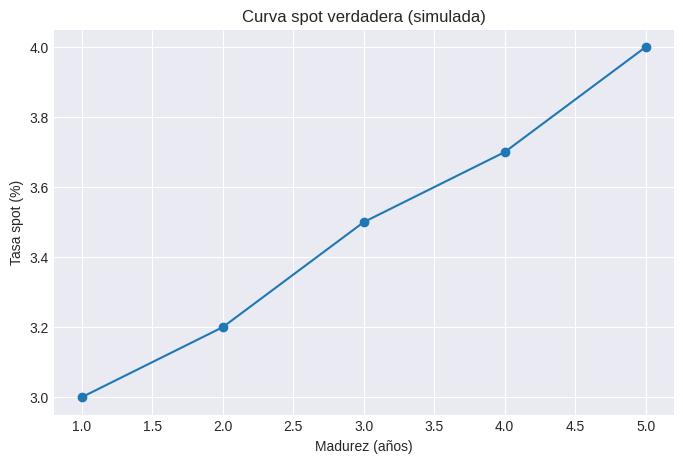

In [54]:
plt.plot(maturities, true_spot * 100, marker="o")
plt.xlabel("Madurez (años)")
plt.ylabel("Tasa spot (%)")
plt.title("Curva spot verdadera (simulada)")
plt.style.use('seaborn-v0_8-darkgrid')
plt.show()


# 3. Bootstrapping de la curva spot a partir de precios de bonos

# 3. Bootstrapping de tasas spot

Supongamos que SOLO observamos:

- los precios de los bonos `Precio_bono`
- el cupón `coupon_rate`
- el nominal `face`
- y sus madureces `1, 2, 3, 4, 5` años.

Queremos **reconstruir la curva spot** \( s(1), s(2), ..., s(5) \).

---

### 3.1. Idea del bootstrapping

Para madurez 1 (bono de 1 año):

$
P_1 = \frac{C + F}{(1 + s(1))^1}
\Rightarrow
s(1) = \frac{C + F}{P_1} - 1
$

Para madurez 2:

$
P_2 = \frac{C}{(1 + s(1))} + \frac{C + F}{(1 + s(2))^2}
$

De aquí podemos despejar \( s(2) \), porque ya conocemos \( s(1) \).
Y así sucesivamente:

$
P_n = \sum_{t=1}^{n-1} \frac{C}{(1 + s(t))^t}
      + \frac{C + F}{(1 + s(n))^n}
$

De esta ecuación despejamos \( s(n) \).  
Ese proceso recursivo es el **bootstrapping** de la curva spot.


In [43]:
def bootstrap_spot_from_bond_prices(face, coupon_rate, maturities, prices):
    """
    Bootstrapping de tasas spot a partir de precios de bonos
    con el MISMO cupón anual y distintos vencimientos.

    Supuestos:
    - Pagos anuales.
    - "maturities" = [1, 2, 3, ...]
    - "prices" son los precios de mercado correspondientes.

    Devuelve:
    - array de tasas spot s(1), s(2), ..., s(n)
    """
    maturities = np.array(maturities, dtype=int)
    prices = np.array(prices, dtype=float)

    max_n = maturities.max()
    spot = np.zeros(max_n)

    C = face * coupon_rate

    for n in maturities:
        Pn = prices[n - 1]  # índice n-1
        # suma de cupones descontados con spots ya encontrados
        if n == 1:
            # P1 = (C + F) / (1 + s1)
            spot[0] = (C + face) / Pn - 1
        else:
            t = np.arange(1, n)  # 1..n-1
            s_prev = spot[:n-1]
            discount_prev = 1 / (1 + s_prev) ** t
            pv_coupons_prev = np.sum(C * discount_prev)

            # Ecuación:
            # Pn = pv_coupons_prev + (C + F)/(1 + s_n)^n
            # (C + F)/(1 + s_n)^n = Pn - pv_coupons_prev
            # (1 + s_n)^n = (C + F) / (Pn - pv_coupons_prev)
            # s_n = [(C + F) / (Pn - pv_coupons_prev)]^(1/n) - 1

            numerator = C + face
            denom = Pn - pv_coupons_prev
            s_n = (numerator / denom) ** (1 / n) - 1
            spot[n - 1] = s_n

    return spot


# APLICACIÓN

In [44]:
boot_spot = bootstrap_spot_from_bond_prices(face, coupon_rate, maturities, prices_market)

df_boot = pd.DataFrame({
    "Madurez_Años": maturities,
    "Spot_verdadero": true_spot,
    "Spot_bootstrapped": boot_spot
})
df_boot


,Madurez_Años,Spot_verdadero,Spot_bootstrapped
0,1,0.030,0.030
1,2,0.032,0.032
2,3,0.035,0.035
3,4,0.037,0.037
4,5,0.040,0.040


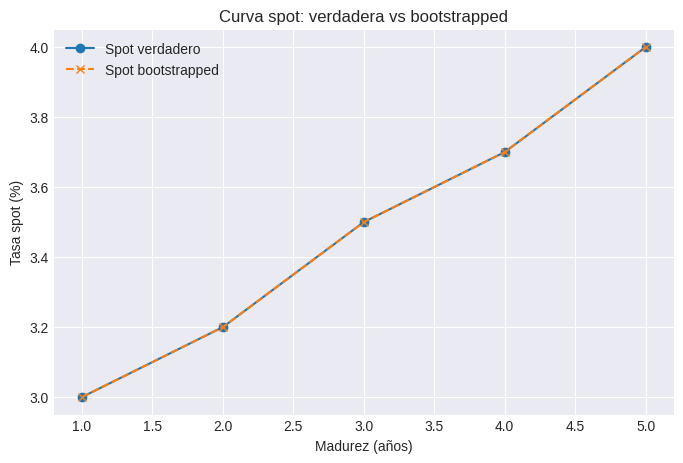

In [55]:
plt.plot(maturities, true_spot * 100, marker="o", label="Spot verdadero")
plt.plot(maturities, boot_spot * 100, marker="x", linestyle="--", label="Spot bootstrapped")
plt.xlabel("Madurez (años)")
plt.ylabel("Tasa spot (%)")
plt.title("Curva spot: verdadera vs bootstrapped")
plt.style.use('seaborn-v0_8-darkgrid')
plt.legend()
plt.show()


### Comentarios

- Como construimos los precios exactamente a partir de `true_spot`,
  el bootstrapping recupera casi la misma curva (salvo errores numéricos).
- En datos reales:
  - Los bonos no son perfectos,
  - hay ruido de mercado, bid/ask, diferencias de liquidez…
  y la curva bootstrapped será una aproximación.
- A partir de esta curva spot podemos construir:
  - Factores de descuento,
  - Tasas forward,
  - Y luego valorar otros instrumentos de renta fija.


# 4. Factores de descuento y tasas forward

Con la curva spot bootstrapped `boot_spot`, calcularemos:

1. **Factores de descuento**:
   $
   DF(T) = \frac{1}{(1 + s(T))^T}
   $

2. **Tasas forward de 1 año** entre:
   - 0→1,
   - 1→2,
   - 2→3,
   - etc.


# Factores de descuento usando la curva bootstrapped

In [46]:

discount_factors = np.array([
    discount_factor(boot_spot[i], maturities[i]) for i in range(len(maturities))
])

# Tasas forward de 1 año f_{T, T+1} para T=0..3 (hasta donde se pueda)
forwards = []
forward_maturities = []

for i in range(len(maturities) - 1):
    T = maturities[i]
    s_T = boot_spot[i]
    s_T1 = boot_spot[i + 1]
    f = forward_rate_1y(s_T, s_T1, T)
    forwards.append(f)
    forward_maturities.append(T)  # forward que empieza en T (entre T y T+1)

df_term = pd.DataFrame({
    "Madurez": maturities,
    "Spot_boot": boot_spot,
    "DF": discount_factors
})
df_forw = pd.DataFrame({
    "Inicio_forward": forward_maturities,
    "Forward_1y": forwards
})

df_term, df_forw


(   Madurez  Spot_boot        DF
 0        1      0.030  0.970874
 1        2      0.032  0.938946
 2        3      0.035  0.901943
 3        4      0.037  0.864739
 4        5      0.040  0.821927,
    Inicio_forward  Forward_1y
 0               1    0.034004
 1               2    0.041026
 2               3    0.043023
 3               4    0.052087)

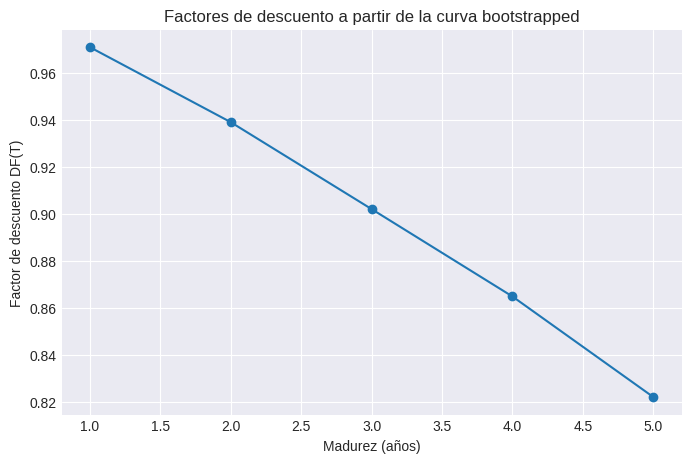

In [56]:
plt.plot(maturities, discount_factors, marker="o")
plt.xlabel("Madurez (años)")
plt.ylabel("Factor de descuento DF(T)")
plt.title("Factores de descuento a partir de la curva bootstrapped")
plt.style.use('seaborn-v0_8-darkgrid')
plt.show()


#Gráfica forward curve

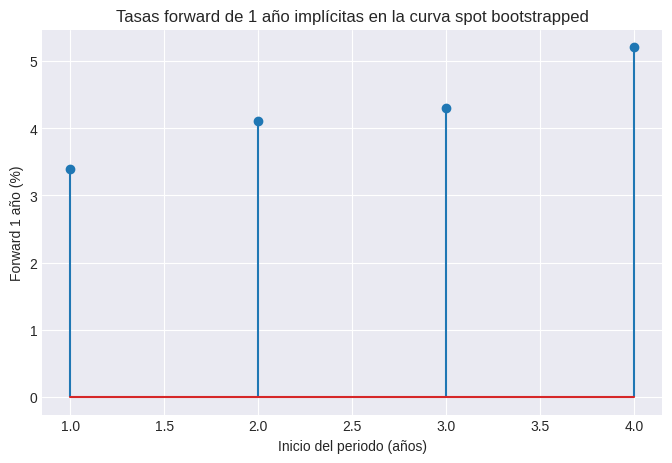

In [57]:
plt.stem(forward_maturities, np.array(forwards) * 100)
plt.xlabel("Inicio del periodo (años)")
plt.ylabel("Forward 1 año (%)")
plt.title("Tasas forward de 1 año implícitas en la curva spot bootstrapped")
plt.style.use('seaborn-v0_8-darkgrid')
plt.show()

# Ajuste de la curva con Nelson–Siegel

El modelo de **Nelson–Siegel** propone que la tasa spot continua (o simple, según convención)
en función de la madurez \( \tau \) se puede aproximar por:

$
s(\tau) = \beta_0
        + \beta_1 \cdot \frac{1 - e^{-\tau / \lambda}}{\tau / \lambda}
        + \beta_2 \cdot \left(
            \frac{1 - e^{-\tau / \lambda}}{\tau / \lambda}
            - e^{-\tau / \lambda}
        \right)
$

Donde:

- \( \beta_0 \): nivel a largo plazo de la curva.
- \( \beta_1 \): pendiente (afecta principalmente el tramo corto).
- \( \beta_2 \): curvatura (hace la panza de la curva).
- \( \lambda \): parámetro de escala que controla dónde se ubica el máximo de la curvatura.

Objetivo:
- Ajustar \( (\beta_0, \beta_1, \beta_2, \lambda) \) a la curva spot `boot_spot` obtenida por bootstrapping.
- Comparar:
  - Spot bootstrapped (puntos)
  - Spot ajustada por Nelson–Siegel (línea suave)


In [49]:
from scipy.optimize import curve_fit
import numpy as np

def nelson_siegel(tau, beta0, beta1, beta2, lamb):
    """
    Función de Nelson–Siegel para la tasa spot en función de la madurez tau.

    tau   : madurez (años)
    betas : parámetros beta0, beta1, beta2
    lamb  : parámetro lambda (>0)
    """
    tau = np.array(tau, dtype=float)
    # Evitar división por cero cuando tau -> 0
    # Usamos un pequeño epsilon
    eps = 1e-6
    x = tau / lamb
    x = np.where(x == 0, eps, x)

    term1 = (1 - np.exp(-x)) / x
    term2 = term1 - np.exp(-x)

    return beta0 + beta1 * term1 + beta2 * term2


# Usamos las madureces y la curva spot bootstrapped del notebook:
 maturities -> [1, 2, 3, 4, 5]
 boot_spot  -> s(1), s(2),..., s(5)

In [50]:
# Usamos las madureces y la curva spot bootstrapped del notebook:
# maturities -> [1, 2, 3, 4, 5]
# boot_spot  -> s(1), s(2),..., s(5)

tau_data = maturities.astype(float)
y_data = boot_spot  # tasas spot observadas (bootstrapped)

# Valores iniciales (heurísticos) para [beta0, beta1, beta2, lambda]
beta0_init = y_data[-1]            # algo cercano a la tasa larga
beta1_init = y_data[0] - y_data[-1]  # diferencia corto-largo
beta2_init = 0.0
lambda_init = 1.0

p0 = [beta0_init, beta1_init, beta2_init, lambda_init]

params_opt, params_cov = curve_fit(nelson_siegel, tau_data, y_data, p0=p0, maxfev=10000)

beta0_hat, beta1_hat, beta2_hat, lambda_hat = params_opt
beta0_hat, beta1_hat, beta2_hat, lambda_hat


(np.float64(0.17113241511940655),
 np.float64(-0.14322088257144552),
 np.float64(-0.10765143726047283),
 np.float64(9.316568076932944))

### Parámetros ajustados

La celda anterior te muestra:

- $ \hat{\beta}_0 $
- $ \hat{\beta}_1 $
- $ \hat{\beta}_2 $
- $ \hat{\lambda} $

Con ellos podemos generar una curva suave de $ s(\tau) $ para madureces entre, por ejemplo, 0.1 y 10 años.


#Generar y graficar la curva Nelson–Siegel

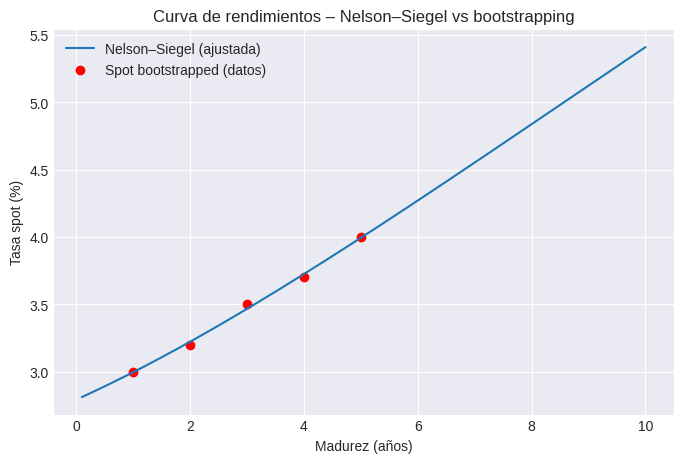

In [58]:
# Rango de madureces suave para graficar
tau_grid = np.linspace(0.1, 10, 200)

spot_ns = nelson_siegel(tau_grid, beta0_hat, beta1_hat, beta2_hat, lambda_hat)

plt.plot(tau_grid, spot_ns * 100, label="Nelson–Siegel (ajustada)")
plt.scatter(maturities, boot_spot * 100, color="red", label="Spot bootstrapped (datos)")
plt.xlabel("Madurez (años)")
plt.ylabel("Tasa spot (%)")
plt.title("Curva de rendimientos – Nelson–Siegel vs bootstrapping")
plt.style.use('seaborn-v0_8-darkgrid')
plt.legend()
plt.show()


#Forwards implícitos en la curva Nelson–Siegel

Podemos usar la curva Nelson–Siegel ajustada para obtener:

- Tasas spot \( s(\tau) \) para cualquier madurez continua (no solo años enteros).
- Tasas forward de 1 año \( f_{T,T+1} \) usando la relación:

$
(1 + s(T+1))^{T+1} = (1 + s(T))^{T} \cdot (1 + f_{T,T+1})
$

De donde:

$
f_{T,T+1} = \frac{(1 + s(T+1))^{T+1}}{(1 + s(T))^{T}} - 1
$

Haremos forwards de 1 año para T = 0, 1, 2, ..., 9.


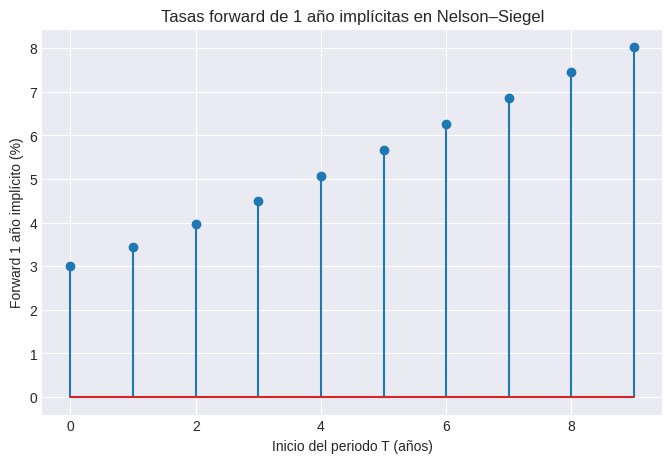

In [59]:
def forward_1y_from_ns(T, beta0, beta1, beta2, lamb):
    """
    Forward 1 año f_{T,T+1} usando la curva Nelson–Siegel ajustada.
    T es entero (0,1,2,...).
    """
    s_T = nelson_siegel(T, beta0, beta1, beta2, lamb)
    s_T1 = nelson_siegel(T + 1, beta0, beta1, beta2, lamb)
    if T == 0:
        # Para T=0, (1 + s(1))^1 = (1 + f_{0,1})
        return (1 + s_T1) - 1
    else:
        return (1 + s_T1) ** (T + 1) / (1 + s_T) ** T - 1

T_vals = np.arange(0, 10)  # forwards desde 0->1 hasta 9->10
forwards_ns = np.array([
    forward_1y_from_ns(T, beta0_hat, beta1_hat, beta2_hat, lambda_hat) for T in T_vals
])

plt.stem(T_vals, forwards_ns * 100)
plt.xlabel("Inicio del periodo T (años)")
plt.ylabel("Forward 1 año implícito (%)")
plt.style.use('seaborn-v0_8-darkgrid')
plt.title("Tasas forward de 1 año implícitas en Nelson–Siegel")
plt.show()

# Conclusiones sobre Nelson–Siegel

- El modelo de **Nelson–Siegel** permite:
  - Suavizar la curva de rendimientos a partir de unos pocos parámetros.
  - Interpolar y extrapolar tasas para madureces que no observamos directamente.
- Los parámetros tienen interpretación económica:
  - $ \beta_0 $: nivel de largo plazo (parte alta de la curva).
  - $ \beta_1 $: pendiente (corto vs largo plazo).
  - $ \beta_2 $: curvatura (zona media).
  - $ \lambda $: controla la posición del “hump” (la panza de la curva).
- A partir de la curva ajustada podemos derivar:
  - Factores de descuento,
  - Tasas forward,
  - Valuación de bonos y otros instrumentos.
